In [1]:
import os
from sklearn.metrics import confusion_matrix
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers as opt
import numpy as np
import gc
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras
import seaborn as sns
from time import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras import regularizers

In [7]:
pip install h5py==2.9

  Using cached h5py-2.9.0.tar.gz (287 kB)
  Running setup.py clean for h5py
Failed to build h5py
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'E:\Anaconda\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Rana\\AppData\\Local\\Temp\\pip-install-8oaox6ea\\h5py\\setup.py'"'"'; __file__='"'"'C:\\Users\\Rana\\AppData\\Local\\Temp\\pip-install-8oaox6ea\\h5py\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Rana\AppData\Local\Temp\pip-wheel-3milkarc'
       cwd: C:\Users\Rana\AppData\Local\Temp\pip-install-8oaox6ea\h5py\
  Complete output (1316 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\h5py
  copying h5py\h5py_warnings.py -> build\lib.win-amd64-3.8\h5py
  copying h5py\highlevel.py -> build\lib.win-amd64-3.8\h5py
  copying h5py\ipy_completer.py -> build\lib.win-amd64-3.8\h5py
  copy

  E:\Anaconda\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Rana\AppData\Local\Temp\pip-install-8oaox6ea\h5py\h5py\_errors.pxd
    tree = Parsing.p_module(s, pxd, full_module_name)
  E:\Anaconda\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Rana\AppData\Local\Temp\pip-install-8oaox6ea\h5py\h5py\_objects.pxd
    tree = Parsing.p_module(s, pxd, full_module_name)
  E:\Anaconda\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Rana\AppData\Local\Temp\pip-install-8oaox6ea\h5py\h5py\_proxy.pxd
    tree = Parsing.p_module(s, pxd, full_module_name)
  E:\Anaconda\lib\site-packages\Cython\Compiler\Main.py

### Get Data

In [2]:
class Input_data:
    def __init__(self, train_data, train_labels, eval_data, eval_labels, max_input_length):
        self.train_data = train_data
        self.train_labels = train_labels
        self.eval_data = eval_data
        self.eval_labels = eval_labels
        self.max_input_length = max_input_length

############################################################################################################

def compute_max(arr, dim="width", z=2):
    mn = np.mean(arr, axis=0)
    sd = np.std(arr, axis=0)
    final_list = [x for x in arr if (x <= mn + z * sd)]  # upper outliers removed
    rmn2 = len(arr) - len(final_list)
    print('{} array size '.format(dim) + str(len(arr)))
    print('min {} '.format(dim) + str(min(arr)))
    print('max {} '.format(dim) + str(max(arr)))
    print('mean {} '.format(dim) + str(np.nanmean(arr)))
    print('standard deviation ' + str(np.std(arr)))
    print('median {} '.format(dim) + str(np.nanmedian(arr)))
    print('number of upper outliers removed ' + str(rmn2))
    print('max {} excluding upper outliers '.format(dim) + str(max(final_list)))
    return max(final_list)


############################################################################################################

def _get_outlier_threshold(path):
    lengths = []
    for root, dirs, files in os.walk(path):
        for f in files:
            filepath = os.path.join(root, f)
            with open(filepath, "r", errors='ignore') as file:
                for line in file:
                    #input_str = line.replace("\t", " ")
                    #input_str = input_str.replace("\n", " ")
                    np_arr = np.fromstring(line, dtype=np.int32, sep=" ")
                    if -1 in np_arr:
                        print("-1 happened")
                    cur_width = len(np_arr)
                    lengths.append(cur_width)
    return compute_max(lengths)


############################################################################################################

def get_outlier_threshold(path, z=1, is_c2v=False):
    len1 = _get_outlier_threshold(os.path.join(path, "Positive"))
    len2 = _get_outlier_threshold(os.path.join(path, "Negative"))
    if len1 > len2:
        return len1
    else:
        return len2


############################################################################################################

def get_data_files(path, max_len):
    input = []
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r',
                  errors='ignore') as file_read:
            for line in file_read:
                #input_str = line.replace("\t", " ")
                #input_str = input_str.replace("\n", " ")
                arr = np.fromstring(line, dtype=np.int32, sep=" ", count=max_len)
                arr_size = len(np.fromstring(line, dtype=np.int32, sep=" "))
                if arr_size <= max_len:
                    arr[arr_size:max_len] = 0
                    input.append(arr)
    return input


############################################################################################################

def get_data(data_path, train_validate_ratio):
    max_input_length = get_outlier_threshold(data_path)

    # Positive cases
    folder_path = os.path.join(data_path, "Positive")
    pos_data_arr = get_data_files(folder_path, max_input_length)
    shuffle(pos_data_arr)
    total_positive_cases = len(pos_data_arr)
    total_positive_labels = np.ones(shape=total_positive_cases, dtype=np.int8)
    print("total positive cases: " + str(total_positive_cases))
    
    # Negative cases
    folder_path = os.path.join(data_path, "Negative")
    neg_data_arr = get_data_files(folder_path, max_input_length)
    shuffle(neg_data_arr)
    total_negative_cases = len(neg_data_arr)
    total_negative_labels = np.zeros(shape=total_negative_cases, dtype=np.int8)
    print("total negative cases: " + str(total_positive_cases))
    
    # Merge positive and Negative cases
    all_data = []
    all_data.extend(pos_data_arr[0:total_positive_cases])
    all_data.extend(neg_data_arr[0:total_negative_cases])
    all_data_arr = np.array(all_data, dtype=np.int32)
    all_data_labels=[]
    all_data_labels.extend(total_positive_labels[0:total_positive_cases])
    all_data_labels.extend(total_negative_labels[0:total_negative_cases])
    all_data = all_data_arr.reshape((len(all_data_labels), max_input_length))
    print("All data: " + str(all_data.shape))
    
    # Apply SMOTE 
    smt = SMOTE(sampling_strategy=0.2)
    all_data,all_data_labels = smt.fit_resample(all_data, all_data_labels)
    print("All data: " + str(all_data.shape))
    
    # Split the new data
    SMOTE_positive_data=[]
    SMOTE_negative_data=[]
    all_data_number= len(all_data_labels)
    for i in range(0, all_data_number):
        if all_data_labels[i] == 1:
            SMOTE_positive_data.append(all_data[i])
        else:
            SMOTE_negative_data.append(all_data[i])
            
    SMOTE_total_positive_cases = len(SMOTE_positive_data)
    SMOTE_total_negative_cases = len(SMOTE_negative_data)
    print("Positive data after applying SMOTE: "+ str(SMOTE_total_positive_cases))
    print("Negative data after applying SMOTE: "+ str(SMOTE_total_negative_cases))
    
    # Split data into training and test portions
    total_training_positive_cases = int(train_validate_ratio * SMOTE_total_positive_cases)
    total_eval_positive_cases = int(total_positive_cases - total_training_positive_cases)

    total_training_negative_cases = int(train_validate_ratio * SMOTE_total_negative_cases)
    total_eval_negative_cases = int(total_negative_cases - total_training_negative_cases)
  

    training_data = []
    training_data.extend(SMOTE_positive_data[0:total_training_positive_cases])
    training_data.extend(SMOTE_negative_data[0:total_training_negative_cases])
    training_data_arr = np.array(training_data, dtype=np.int32)

    training_labels = np.empty(shape=[len(training_data_arr)], dtype=np.int8)
    training_labels[0:total_training_positive_cases] = 1
    training_labels[total_training_positive_cases:len(training_data_arr)] = 0

    eval_data = []
    eval_data.extend(SMOTE_positive_data[len(pos_data_arr) - total_eval_positive_cases:])
    eval_data.extend(neg_data_arr[len(neg_data_arr) - total_eval_negative_cases:])
    eval_data_arr = np.array(eval_data, dtype=np.int32)

    eval_labels = np.empty(shape=[len(eval_data_arr)], dtype=np.int8)
    eval_labels[0:total_eval_positive_cases] = 1
    eval_labels[total_eval_positive_cases:] = 0
    
    training_data = training_data_arr.reshape((len(training_data_arr), max_input_length))
    eval_data = eval_data_arr.reshape((len(eval_labels), max_input_length))
    training_data,training_labels = shuffle(training_data,training_labels)
    eval_data, eval_labels = shuffle(eval_data, eval_labels)

    return training_data, training_labels, eval_data, eval_labels, max_input_length

############################################################################################################

def get_all_data(data_path):
    print("reading data...")

    train_data, train_labels, eval_data, eval_labels, max_input_length = \
        get_data(data_path, train_validate_ratio=TRAIN_VALIDATE_RATIO )
    print("nan count: " + str(np.count_nonzero(np.isnan(train_data))))
    print("train_data: " + str(len(train_data)))
    print("train_data shape: " + str(train_data.shape))
    print("eval_data: " + str(len(eval_data)))
    print("eval_labels: " + str(len(eval_labels)))
    print("reading data... done.")
    input_data = Input_data(train_data, train_labels, eval_data, eval_labels, max_input_length)
    return input_data

In [3]:
TRAIN_VALIDATE_RATIO = 0.7
OUT_FOLDER = "D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\Result"
data_path = "D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\ExtractedData\\TokenizedSamples"
smell = "FeatureEnvy"
input_data = get_all_data(data_path)

reading data...


<ipython-input-2-085ad2bc2093>:38: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  np_arr = np.fromstring(line, dtype=np.int32, sep=" ")


width array size 657
min width 1
max width 11042
mean width 874.1963470319635
standard deviation 986.7706316872611
median width 563.0
number of upper outliers removed 29
max width excluding upper outliers 2846
width array size 89490
min width 1
max width 124904
mean width 439.5406078891496
standard deviation 1180.7498737561382
median width 189.0
number of upper outliers removed 1486
max width excluding upper outliers 2801


<ipython-input-2-085ad2bc2093>:67: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  arr = np.fromstring(line, dtype=np.int32, sep=" ", count=max_len)
<ipython-input-2-085ad2bc2093>:68: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  arr_size = len(np.fromstring(line, dtype=np.int32, sep=" "))


total positive cases: 628
total negative cases: 628
All data: (88691, 2846)
All data: (105675, 2846)
Positive data after applying SMOTE: 17612
Negative data after applying SMOTE: 88063
nan count: 0
train_data: 73972
train_data shape: (73972, 2846)
eval_data: 31703
eval_labels: 31703
reading data... done.


In [4]:
def write_result(file, str):
    f = open(file, "a+")
    f.write(str)
    f.close()
    
def get_out_file(smell):
    now = datetime.datetime.now()
    if not os.path.exists(OUT_FOLDER):
        os.makedirs(OUT_FOLDER)
    return os.path.join(OUT_FOLDER, "ae_" + smell + "_"
                        + str(now.strftime("%d%m%Y_%H%M") + ".csv"))

############################################################################################################

def find_metrics(error_df, threshold):
    y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, y_pred)
    precision, recall, f1 = compute_metrics(conf_matrix)
    return threshold, precision, recall, f1

############################################################################################################

def compute_metrics(conf_matrix):
    precision = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
    recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
    f1 = (2 * precision * recall) / (precision + recall)
    print("precision: " + str(precision) + ", recall: " + str(recall) + ", f1: " + str(f1))
    return precision, recall, f1

############################################################################################################

def get_predicted_y(prob, threshold):
    out_arr = np.empty(len(prob), dtype=np.int32)
    for i in range(0, len(prob)):
        if prob[i] > threshold:
            out_arr[i] = 1
        else:
            out_arr[i] = 0
    return out_arr

In [5]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def get_all_metrics(model, eval_data, eval_labels, pred_labels):
    fpr, tpr, thresholds_keras = roc_curve(eval_labels, pred_labels)
    auc_ = auc(fpr, tpr)
    print("auc_keras:" + str(auc_))

    score = model.evaluate(eval_data, eval_labels, verbose=0)
    print("Test accuracy: " + str(score[1]))

    precision = precision_score(eval_labels, pred_labels)
    print('Precision score: {0:0.2f}'.format(precision))

    recall = recall_score(eval_labels, pred_labels)
    print('Recall score: {0:0.2f}'.format(recall))

    f1 = f1_score(eval_labels, pred_labels)
    print('F1 score: {0:0.2f}'.format(f1))

    average_precision = average_precision_score(eval_labels, pred_labels)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    return auc_, score[1], precision, recall, f1, average_precision, fpr, tpr

############################################################################################################

def get_all_metrics_(eval_labels, pred_labels):
    fpr, tpr, thresholds_keras = roc_curve(eval_labels, pred_labels)
    auc_ = auc(fpr, tpr)
    print("auc_keras:" + str(auc_))

    precision = precision_score(eval_labels, pred_labels)
    print('Precision score: {0:0.2f}'.format(precision))

    recall = recall_score(eval_labels, pred_labels)
    print('Recall score: {0:0.2f}'.format(recall))

    f1 = f1_score(eval_labels, pred_labels)
    print('F1 score: {0:0.2f}'.format(f1))

    average_precision = average_precision_score(eval_labels, pred_labels)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    return auc_, precision, recall, f1, average_precision, fpr, tpr

In [6]:
from inspect import signature
import matplotlib.pyplot as plt
import datetime
import os
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def save_roc_curve(eval_labels, pred_labels, file_name):
    fig = plt.figure()
    lw = 2
    fpr, tpr, _=roc_curve(eval_labels, pred_labels)
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)')
    plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    fig.savefig(file_name)

def save_precision_recall_curve(eval_labels, pred_labels, file_name):
    fig = plt.figure()
    precision, recall, _ = precision_recall_curve(eval_labels, pred_labels)

    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    fig.savefig(file_name)

# AutoEncoders


In [23]:
from sklearn.model_selection import cross_val_score

# Binary Classification with Sonar Dataset: Baseline
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True)

def autoencoder_dense(data, smell, no_of_layers=1, encoding_dimension=32, epochs=10, with_bottleneck=True, threshold=400000):
    input_layer = Input(shape=(data.max_input_length,))
    prev_layer = input_layer
    for i in range(no_of_layers):
        encoder = Dense(int(encoding_dimension / pow(2, i)), activation="relu",
                        activity_regularizer=regularizers.l1(10e-3))(prev_layer)
        prev_layer = encoder
    # bottleneck
    if with_bottleneck:
        prev_layer = Dense(int(encoding_dimension / pow(2, no_of_layers)), activation="relu")(prev_layer)
    for j in range(no_of_layers - 1, -1, -1):
        decoder = Dense(int(encoding_dimension / pow(2, j)), activation='relu')(prev_layer)
        prev_layer = decoder
    prev_layer = Dense(data.max_input_length, activation='relu')(prev_layer)
    prev_layer = Dense(1, activation='sigmoid')(prev_layer)
    autoencoder = Model(inputs=input_layer, outputs=prev_layer)

    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['accuracy'])
    autoencoder.summary()
    history = autoencoder.fit(data.train_data,
                              data.train_labels,
                              epochs=epochs,
                              batch_size=32,
                              verbose=1,
                              shuffle=True).history

    plt.plot(history['loss'])
#     plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    filename3= 'D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\Result\\AutoEncoder\\smote_ae_256'+'\\model.png' 
    #SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))
    plot_model(autoencoder, to_file=filename3, show_shapes=True)
    
    prob = autoencoder.predict(data.eval_data)
    
    y_pred = get_predicted_y(prob, 0.5) 
    
    
    auc, accuracy, precision, recall, f1, average_precision, fpr, tpr = get_all_metrics(autoencoder, data.eval_data, data.eval_labels, y_pred)
    
    filename1= 'D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\Result\\AutoEncoder\\smote_ae_256\\roc_curve.png' 
    filename2= 'D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\Result\\AutoEncoder\\smote_ae_256\\precision_recall_curve.png'           
    save_roc_curve(data.eval_labels, y_pred, filename1)
    save_precision_recall_curve(data.eval_labels, y_pred,filename2)
    
    #predictions = autoencoder.predict(data.eval_data)
    mse = np.mean(np.power(data.eval_data - prob, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse,
                             'True_class': data.eval_labels})
    
    save_roc_curve(data.eval_labels, y_pred, filename1)
    save_precision_recall_curve(data.eval_labels, y_pred,filename2)
    
    return find_metrics(error_df, threshold)

############################################################################################################

def autoencoder(smell, input_data, layer, epochs=20, encoding=1024, bottleneck=True, threshold=400000):
    outfile = get_out_file(smell)
    write_result(outfile,
                 "Encoding_dim,threshold,epoch,bottleneck,layer,precision,recall,f1,time\n")
    #start_time = time.time()
    try:
        optimal_threshold, max_pr, max_re, max_f1 = autoencoder_dense(input_data, smell, no_of_layers=layer,
                                                                      epochs=epochs,
                                                                      encoding_dimension=encoding,
                                                                      with_bottleneck=bottleneck,
                                                                      threshold=threshold)
    except ValueError as error:
        print(error)
    #end_time = time.time()
    #time_taken = end_time - start_time
    #write_result(outfile,str(encoding) + "," + str(optimal_threshold) + "," + str(epochs) + "," + str(bottleneck) + "," + str(layer) + "," +str(max_pr) + "," + str(max_re) + "," + str(max_f1) + "," + str(time_taken) + "\n")

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2846)]            0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                91104     
_________________________________________________________________
dense_33 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_34 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_35 (Dense)             (None, 2846)              93918     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 2847      
Total params: 188,941
Trainable params: 188,941
Non-trainable params: 0
_____________________________________________________

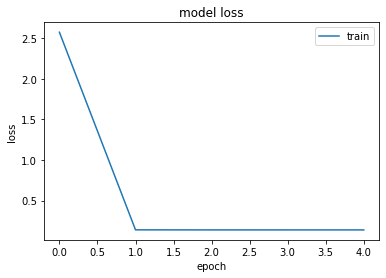

auc_keras:0.5
Test accuracy: 0.3690502345561981
Precision score: 0.00
Recall score: 0.00
F1 score: 0.00
Average precision-recall score: 0.63


E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: 0.6259498543835571, recall: 0.93480977853322, f1: 0.7498195524901756


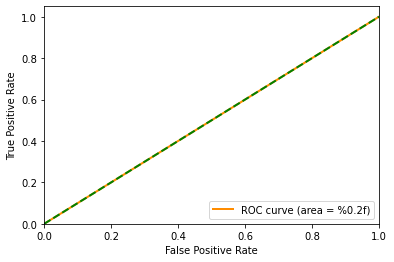

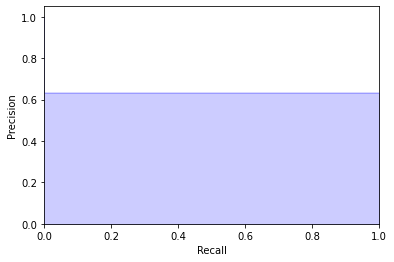

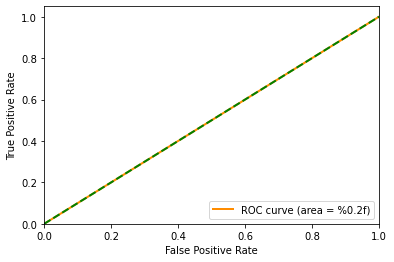

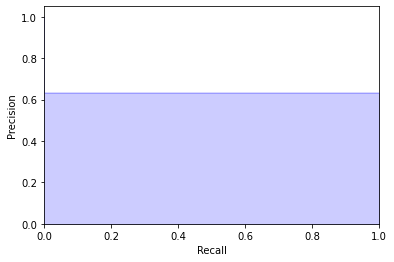

In [24]:
autoencoder("FeatureEnvy", input_data=input_data, layer=1,epochs=5, encoding=32, bottleneck=True, threshold=319000)

# CNN

In [21]:
def CNN(data, batch_size,epochs_number,emb_output, out_folder):
    
    
    max_features = int(max(np.max(data.train_data), np.max(data.eval_data)))
    min_features= int(min(np.min(data.train_data), np.min(data.eval_data)))
    print("max_features: ",max_features)
    print("min_features: ",min_features)
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(data.max_input_length,)))
    model.add(tf.keras.layers.Embedding(input_dim=max_features + 1,output_dim=emb_output,mask_zero=True))
    #model.add(tf.keras.layers.Conv1D(32, 11, activation='relu'))
    model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D((5), strides=2))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    model.summary()
    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1,mode='auto')
    
    history= model.fit(data.train_data, data.train_labels, validation_split=0.2, epochs=epochs_number,batch_size=batch_size, verbose=1, shuffle=True).history
    
    plt.plot(history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    prob = model.predict(data.eval_data)
    y_pred = get_predicted_y(prob, 0.5)
    try:
        auc, accuracy, precision, recall, f1, average_precision, fpr, tpr = get_all_metrics(model, data.eval_data, data.eval_labels, y_pred)
    except Exception as e:
        print(e)
    
    filename1= out_folder+'\\roc_curve.png' 
    filename2= out_folder+'\\precision_recall_curve.png' 
    filename3= out_folder+'\\model.png' 
    
    save_roc_curve(data.eval_labels, y_pred, filename1)
    save_precision_recall_curve(data.eval_labels, y_pred,filename2)
    plot_model(model, to_file=filename3, show_shapes=True)
    #model.save(out_folder+'\\weights.hdf5')
    
    return auc, accuracy, precision, recall, f1, average_precision

max_features:  534429
min_features:  0
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2846, 16)          8550880   
_________________________________________________________________
conv1d (Conv1D)              (None, 2842, 16)          1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1419, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1419, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 22704)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                726560    
_________________________________________________________________
dense_30 (Dense

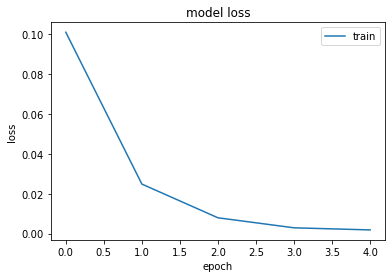

auc_keras:0.6315044794562866
Test accuracy: 0.5355328917503357
Precision score: 1.00
Recall score: 0.27
F1 score: 0.42
Average precision-recall score: 0.73


(0.6315044794562866,
 0.5355328917503357,
 0.9954938039804732,
 0.26506024096385544,
 0.41865055864818984,
 0.7275758865460434)

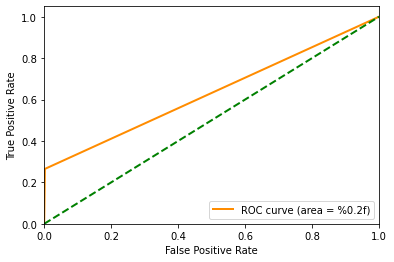

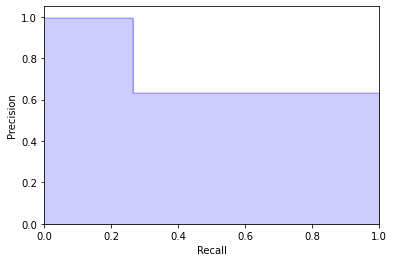

In [22]:
out_folder = "D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\Result\\CNN\\smote_cnn_256"
CNN(input_data,256,5,16,out_folder)

# LSTM

In [42]:
def LSTM(data, batch_size,epochs_number,emb_output, out_folder):
    
    
    max_features = int(max(np.max(data.train_data), np.max(data.eval_data)))
    min_features= int(min(np.min(data.train_data), np.min(data.eval_data)))
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(data.max_input_length,)))
    model.add(tf.keras.layers.Embedding(input_dim=max_features + 1,output_dim=emb_output,mask_zero=True))
    #model.add(tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.1, dropout=0.1))
    model.add(tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.1, dropout=0.1))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    model.summary()
    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1,mode='auto')
    
    history= model.fit(data.train_data, data.train_labels, validation_split=0.2, epochs=epochs_number,batch_size=batch_size, verbose=1, shuffle=True).history
    
    plt.plot(history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    prob = model.predict(data.eval_data)
    y_pred = get_predicted_y(prob, 0.5)
    try:
        auc, accuracy, precision, recall, f1, average_precision, fpr, tpr = get_all_metrics(model, data.eval_data, data.eval_labels, y_pred)
    except Exception as e:
        print(e)
    
    filename1= out_folder+'\\roc_curve.png' 
    filename2= out_folder+'\\precision_recall_curve.png' 
    filename3= out_folder+'\\model.png' 
    
    save_roc_curve(data.eval_labels, y_pred, filename1)
    save_precision_recall_curve(data.eval_labels, y_pred,filename2)
    plot_model(model, to_file=filename3, show_shapes=True)
    #model.save(out_folder+'\\weights.hdf5')
    
    return auc, accuracy, precision, recall, f1, average_precision

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2846, 16)          8550880   
_________________________________________________________________
lstm (LSTM)                  (None, 2846, 32)          6272      
_________________________________________________________________
dropout_6 (Dropout)          (None, 2846, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 91072)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               9107300   
_________________________________________________________________
dense_19 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

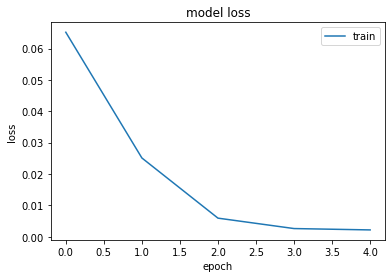

auc_keras:0.6307779986848127
Test accuracy: 0.5356906056404114
Precision score: 0.99
Recall score: 0.27
F1 score: 0.42
Average precision-recall score: 0.73


(0.6307779986848127,
 0.5356906056404114,
 0.9867330016583747,
 0.2677098435234715,
 0.4211561148250098,
 0.726196430379443)

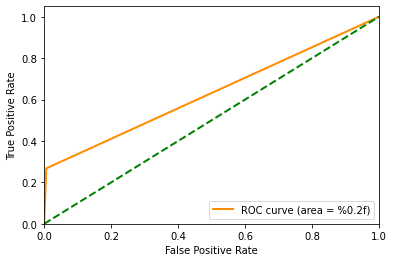

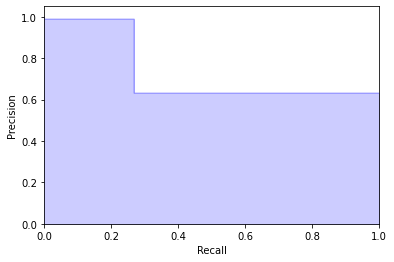

In [43]:
out_folder = "D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\Result\\LSTM\\smote_lstm_256"
LSTM(input_data,256,5,16,out_folder)

# Bidirectional LSTM

In [10]:
def BI_LSTM(data, batch_size,epochs_number,emb_output, out_folder):
    
    
    max_features = int(max(np.max(data.train_data), np.max(data.eval_data)))
    min_features= int(min(np.min(data.train_data), np.min(data.eval_data)))
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(data.max_input_length,)))
    model.add(tf.keras.layers.Embedding(input_dim=max_features + 1,output_dim=emb_output,mask_zero=True))

    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
    #model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    model.summary()
    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1,mode='auto')
    
    history= model.fit(data.train_data, data.train_labels, validation_split=0.2, epochs=epochs_number,batch_size=batch_size, verbose=1, shuffle=True).history
    
    plt.plot(history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    prob = model.predict(data.eval_data)
    y_pred = get_predicted_y(prob, 0.5)
    try:
        auc, accuracy, precision, recall, f1, average_precision, fpr, tpr = get_all_metrics(model, data.eval_data, data.eval_labels, y_pred)
    except Exception as e:
        print(e)
    
    filename1= out_folder+'\\roc_curve.png' 
    filename2= out_folder+'\\precision_recall_curve.png' 
    filename3= out_folder+'\\model.png' 
              
    save_roc_curve(data.eval_labels, y_pred, filename1)
    save_precision_recall_curve(data.eval_labels, y_pred,filename2)
    plot_model(model, to_file=filename3, show_shapes=True)
    #model.save(out_folder+'\\weights.hdf5')
    
    return auc, accuracy, precision, recall, f1, average_precision

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2846, 16)          8550880   
_________________________________________________________________
bidirectional (Bidirectional (None, 2846, 128)         41472     
_________________________________________________________________
dropout (Dropout)            (None, 2846, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 364288)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               36428900  
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

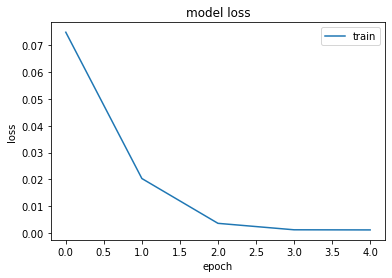

auc_keras:0.6256014802907769
Test accuracy: 0.5349336266517639
Precision score: 0.94
Recall score: 0.28
F1 score: 0.43
Average precision-recall score: 0.72


(0.6256014802907769,
 0.5349336266517639,
 0.9442473390775469,
 0.279408088786682,
 0.43121672710439013,
 0.7184876323073889)

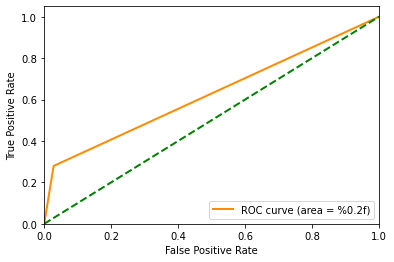

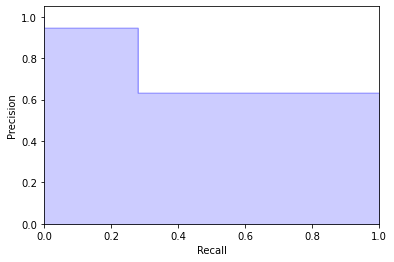

In [11]:
out_folder = "D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\Result\\BI_LSTM\\smote_bi_lstm_256"
BI_LSTM(input_data,256,5,16,out_folder)

# GRU

In [12]:
def GRU(data, batch_size,epochs_number,emb_output, out_folder):
    
    
    max_features = int(max(np.max(data.train_data), np.max(data.eval_data)))
    min_features= int(min(np.min(data.train_data), np.min(data.eval_data)))
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(data.max_input_length,)))
    model.add(tf.keras.layers.Embedding(input_dim=max_features + 1,output_dim=emb_output,mask_zero=True))

    #model.add(tf.keras.layers.GRU(64, return_sequences=True, recurrent_dropout=0.1, dropout=0.1))
    model.add(tf.keras.layers.GRU(32, return_sequences=True, recurrent_dropout=0.1, dropout=0.1))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    model.summary()
    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1,mode='auto')
    
    history= model.fit(data.train_data, data.train_labels, validation_split=0.2, epochs=epochs_number,batch_size=batch_size, verbose=1, shuffle=True).history
    
    plt.plot(history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    prob = model.predict(data.eval_data)
    y_pred = get_predicted_y(prob, 0.5)
    try:
        auc, accuracy, precision, recall, f1, average_precision, fpr, tpr = get_all_metrics(model, data.eval_data, data.eval_labels, y_pred)
    except Exception as e:
        print(e)
    
    filename1= out_folder+'\\roc_curve.png' 
    filename2= out_folder+'\\precision_recall_curve.png' 
    filename3= out_folder+'\\model.png' 
    
    save_roc_curve(data.eval_labels, y_pred, filename1)
    save_precision_recall_curve(data.eval_labels, y_pred,filename2)
    plot_model(model, to_file=filename3, show_shapes=True)
    #model.save(out_folder+'\\weights.hdf5')
    
    return auc, accuracy, precision, recall, f1, average_precision

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2846, 16)          8550880   
_________________________________________________________________
gru (GRU)                    (None, 2846, 32)          4800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2846, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 91072)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               9107300   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

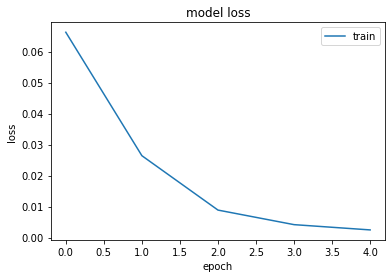

auc_keras:0.6307731553942123
Test accuracy: 0.5354382991790771
Precision score: 0.99
Recall score: 0.27
F1 score: 0.42
Average precision-recall score: 0.73


(0.6307731553942123,
 0.5354382991790771,
 0.9886974244950899,
 0.26675998600209966,
 0.42015748031496064,
 0.726382516392571)

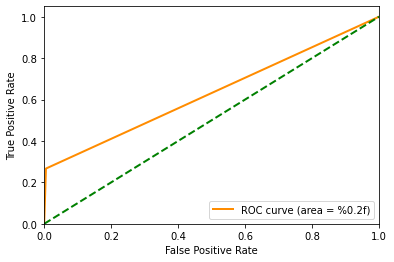

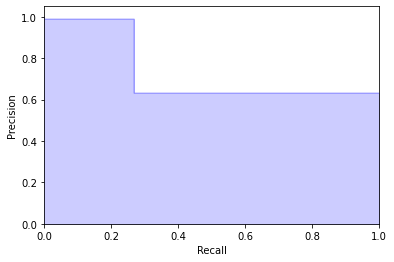

In [13]:
out_folder = "D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\Result\\GRU\\smote_gru_256"
GRU(input_data,256,5,16,out_folder)

# Bidirectional GRU

In [14]:
def BI_GRU(data, batch_size,epochs_number,emb_output, out_folder):
    
    
    max_features = int(max(np.max(data.train_data), np.max(data.eval_data)))
    min_features= int(min(np.min(data.train_data), np.min(data.eval_data)))
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(data.max_input_length,)))
    model.add(tf.keras.layers.Embedding(input_dim=max_features + 1,output_dim=emb_output,mask_zero=True))

    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
    #model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    model.summary()
    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1,mode='auto')
    
    history= model.fit(data.train_data, data.train_labels, validation_split=0.2, epochs=epochs_number,batch_size=batch_size, verbose=1, shuffle=True).history
    
    plt.plot(history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    prob = model.predict(data.eval_data)
    y_pred = get_predicted_y(prob, 0.5)
    try:
        auc, accuracy, precision, recall, f1, average_precision, fpr, tpr = get_all_metrics(model, data.eval_data, data.eval_labels, y_pred)
    except Exception as e:
        print(e)
    
    filename1= out_folder+'\\roc_curve.png' 
    filename2= out_folder+'\\precision_recall_curve.png' 
    filename3= out_folder+'\\model.png' 
              
    save_roc_curve(data.eval_labels, y_pred, filename1)
    save_precision_recall_curve(data.eval_labels, y_pred,filename2)
    plot_model(model, to_file=filename3, show_shapes=True)
    #model.save(out_folder+'\\weights.hdf5')
    
    return auc, accuracy, precision, recall, f1, average_precision

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2846, 16)          8550880   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2846, 128)         31488     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2846, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 364288)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               36428900  
_________________________________________________________________
dense_7 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

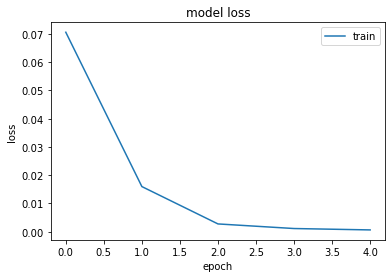

auc_keras:0.6307868606033881
Test accuracy: 0.5353436470031738
Precision score: 0.99
Recall score: 0.27
F1 score: 0.42
Average precision-recall score: 0.73


(0.6307868606033881,
 0.5353436470031738,
 0.9895988112927192,
 0.26636004599310104,
 0.4197423878362942,
 0.7264795322142439)

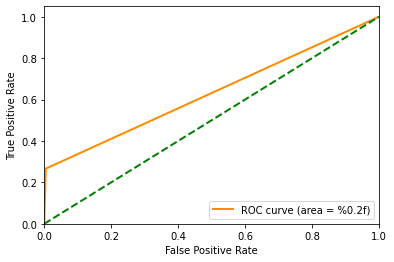

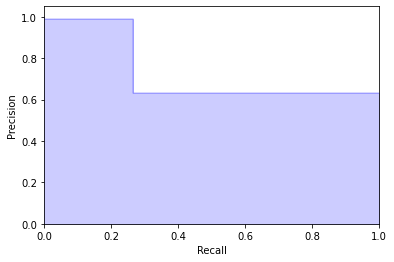

In [15]:
out_folder = "D:\\Master\\Thesis\\CodeSmellsDetector\\DL_Approach\\Result\\BI_GRU\\smote_bi_gru_256"
BI_GRU(input_data,256,5,16,out_folder)